In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import roc_auc_score 
from typing import List 
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import implicit
from implicit.als import AlternatingLeastSquares
import itertools
from tqdm import tqdm
import os  

In [2]:
# Importing the aisle, department and product datasets
read_path = './data/'
save_path = './results/'
fig_save_path = "./figure/"
df_aisles = pd.read_csv(read_path+'aisles.csv', low_memory=False) 
df_departments = pd.read_csv(read_path+'departments.csv', low_memory=False) 
df_products = pd.read_csv(read_path+'products.csv', low_memory=False)

# Importing the order datasets
df_orders = pd.read_csv(read_path+'orders.csv', low_memory=False) 
# orders prior to that users most recent order
df_order_prior = pd.read_csv(read_path+'order_products__prior.csv', low_memory=False) 
# serve as a test set for the my CF model
df_order_test = pd.read_csv(read_path+'order_products__train.csv', low_memory=False) 

In [3]:
#Merge the dataframes to get the user ids for each order
prior_orders_merged=df_order_prior.merge(df_orders.loc[:,["user_id","order_id"]],on='order_id')
prior_orders_merged.drop(["add_to_cart_order"],axis=1,inplace=True) # serve as the memory of the CF ineraction matrix

In [4]:
#Merge test dataframe to alse get user ids along with the orders
test_orders_merged=df_order_test.merge(df_orders.loc[:,["user_id","order_id"]],on='order_id')
test_orders_merged.drop(["add_to_cart_order"],axis=1,inplace=True) # serve as the test set for CF recommenders

In [5]:
class FlexibleRecommenderPreprocessor: 
    def __init__(self, df_products: pd.DataFrame): 
        """
        Initialize the preprocessor with product metadata.
        """
        self.df_products = df_products.copy()

    def select_products(
        self,
        df_orders: pd.DataFrame,
        method: str = 'stratified',
        n: int = 1000,
        stratum_ratios: tuple = (0.5, 0.3, 0.2)
    ) -> pd.DataFrame:
        """
        Select products using either 'top_n' or 'stratified' method.

        Parameters:
        - df_orders (pd.DataFrame): Orders data containing 'product_id'.
        - method (str): 'top_n' or 'stratified'.
        - n (int): Number of products to sample.
        - stratum_ratios (tuple): Required only for 'stratified'.

        Returns:
        - pd.DataFrame: Selected product dataframe with metadata.
        """
        if method == 'top_n':
            return self._get_top_n_products(df_orders, n)
        elif method == 'stratified':
            return self._stratified_sampling(df_orders, stratum_ratios, n)
        else:
            raise ValueError("Invalid method. Use 'top_n' or 'stratified'.")

    def _get_top_n_products(self, df, n):
        ampled_df = df.groupby('product_id').size().nlargest(n).reset_index(name='purchase_count')
        ampled_df = ampled_df.merge(self.df_products, on='product_id', how='left', validate='1:1')
        return ampled_df

    def _stratified_sampling(self, df, stratum_ratios, n):
        assert sum(stratum_ratios) == 1.0, "Ratios must sum to 1.0"

        product_counts = df['product_id'].value_counts().reset_index()
        product_counts.columns = ['product_id', 'purchase_count']

        high_thresh = product_counts['purchase_count'].quantile(0.95)
        mid_thresh = product_counts['purchase_count'].quantile(0.70)

        high_freq_products = product_counts[product_counts['purchase_count'] >= high_thresh]
        mid_freq_products = product_counts[(product_counts['purchase_count'] < high_thresh) & (product_counts['purchase_count'] >= mid_thresh)]
        low_freq_products = product_counts[product_counts['purchase_count'] < mid_thresh]

        n_high = int(n * stratum_ratios[0])
        n_mid = int(n * stratum_ratios[1])
        n_low = n - n_high - n_mid

        sampled_high = high_freq_products.sample(n=min(n_high, len(high_freq_products)), random_state=42)
        sampled_mid = mid_freq_products.sample(n=min(n_mid, len(mid_freq_products)), random_state=42)
        sampled_low = low_freq_products.sample(n=min(n_low, len(low_freq_products)), random_state=42)

        sampled_products = pd.concat([sampled_high, sampled_mid, sampled_low]).reset_index(drop=True)
        sampled_df = sampled_products.merge(self.df_products, on='product_id', how='left', validate='1:1')

        return sampled_df

    def get_top_n_products_in_orders(self, df_orders, df_selected_products):
        filtered_orders = df_orders[df_orders['product_id'].isin(df_selected_products['product_id'])]
        filtered_orders = filtered_orders.drop(columns=['order_id', 'reordered'], errors='ignore')
        return filtered_orders

    def get_user_product_interaction_matrix(self, df_filtered_orders):
        interaction_matrix = df_filtered_orders.pivot_table(
            index='user_id', columns='product_id', aggfunc='size', fill_value=0
        ).astype(np.int8)
        return interaction_matrix

    def get_user_product_dict(self, df_filtered_orders):
        user_product_dict = (
            df_filtered_orders.groupby('user_id')['product_id']
            .apply(lambda x: list(set(x)))
            .to_dict()
        )
        return user_product_dict

    def get_user_purchase_count(self, df_filtered_orders):
        return df_filtered_orders.groupby('user_id').size()

In [6]:
class WeightedInteractionMatrixBuilder: 
    def __init__(self, df_orders_all: pd.DataFrame, df_order_meta: pd.DataFrame):
        """  
        Parameters:  
        - df_orders_all: All orders containing user_id, product_id, and order_id (e.g., prior part)  
        - df_order_meta: Metadata containing order_id, user_id, and order_number (from orders.csv)  
        """  
        self.df_orders_all = df_orders_all.copy() # Copy the orders DataFrame
        self.df_order_meta = df_order_meta[['order_id', 'user_id', 'order_number']].copy() # Copy relevant metadata 

    def get_frequency_weighted_matrix(self, filtered_products: pd.DataFrame) -> pd.DataFrame:
        """  
        Construct a user-product interaction matrix based on purchase frequency  
        """  
        df = self.df_orders_all[self.df_orders_all['product_id'].isin(filtered_products['product_id'])] # Filter orders for selected products
        freq_df = df.groupby(['user_id', 'product_id']).size().reset_index(name='purchase_count') # Group by user and product to count purchases 

        matrix = freq_df.pivot_table(
            index='user_id', # Set user_id as index  
            columns='product_id', # Set product_id as columns 
            values='purchase_count', # Use purchase_count as values
            fill_value=0 # Fill missing values with 0
        ).astype(np.int16)  # Convert to int16 for memory efficiency

        return matrix

    def get_time_weighted_matrix(self, filtered_products: pd.DataFrame, lambda_decay: float = 0.1) -> pd.DataFrame:
        """  
        Construct a user-product interaction matrix based on time decay  
        """  
        df = self.df_orders_all[self.df_orders_all['product_id'].isin(filtered_products['product_id'])]# Filter orders for selected products
        df = df.merge(self.df_order_meta, on=['order_id', 'user_id'], how='left')# Merge with order metadata

        # Get the latest order number for each user 
        user_latest_order = df.groupby('user_id')['order_number'].max().rename('latest_order_number')  
        df = df.merge(user_latest_order, on='user_id') # Merge latest order info back to df

        # Calculate time difference delta_t (the more recent, the smaller it is)
        df['delta_t'] = df['latest_order_number'] - df['order_number']

        # Apply time decay weight 
        df['time_weight'] = np.exp(-lambda_decay * df['delta_t'])

        # Aggregate the weights for each user-product (sum up weights if repurchased multiple times)
        weighted_df = df.groupby(['user_id', 'product_id'])['time_weight'].sum().reset_index() # Sum weights for each user-product pair

        matrix = weighted_df.pivot_table(
            index='user_id', # Set user_id as index  
            columns='product_id',
            values='time_weight',
            fill_value=0
        )

        return matrix

In [7]:
class SimilarityPreprocessor:
    def __init__(self, user_product_interaction: pd.DataFrame, 
                 orders: pd.DataFrame = None, 
                 products: pd.DataFrame = None):
        """
        Initialize the preprocessor for computing similarity between users.

        Parameters:
        - user_product_interaction (pd.DataFrame): A matrix where rows are users, columns are product_ids, 
                                                   and values represent interaction counts (e.g., number of purchases).
        - orders (pd.DataFrame, optional): Orders DataFrame containing user_id, order_number, and eval_set. 
                                           If not provided, defaults to global df_orders.
        - products (pd.DataFrame, optional): Products DataFrame containing product_id and product_name. 
                                             If not provided, defaults to global df_products.
        """
        self.user_product_interaction = user_product_interaction
        self.orders = orders if orders is not None else df_orders
        self.products = products if products is not None else df_products
        self.normalized_matrix = None # Cached normalized interaction matrix

    def normalize_interaction(self) -> pd.DataFrame:
        """
        Normalize the interaction matrix by dividing each user's interaction counts 
        by their total number of orders.

        This accounts for differences in user activity levels and makes interactions comparable.

        Returns:
        - pd.DataFrame: Normalized interaction matrix with product names as columns.
        """
        # Filter only users present in the interaction matrix
        users_in_matrix = self.user_product_interaction.index.tolist()
        # Use only "prior" orders to calculate order counts per user
        orders_train = self.orders[self.orders["eval_set"] == "prior"]
        # Align users with interaction matrix
        orders_per_user = orders_train.groupby("user_id")["order_number"].max()
        orders_per_user = orders_per_user[orders_per_user.index.isin(users_in_matrix)]
        filtered_matrix = self.user_product_interaction.loc[orders_per_user.index]
        # Normalize by dividing each user's row by their total number of orders
        user_product_interaction_scaled = filtered_matrix.div(orders_per_user, axis=0)

        # Map product_id to product_name
        products_in_matrix = self.products[
            self.products["product_id"].isin(user_product_interaction_scaled.columns)
        ][["product_id", "product_name"]].drop_duplicates()
        product_name_map = dict(zip(products_in_matrix["product_id"], products_in_matrix["product_name"]))

        # Replace product_id column names with product names (for interpretability)
        user_product_interaction_scaled.columns = [
            product_name_map.get(pid, pid) for pid in user_product_interaction_scaled.columns
        ]

        self.normalized_matrix = user_product_interaction_scaled
        return user_product_interaction_scaled

    def get_sample_users(self, n: int) -> pd.DataFrame:
        """
        Randomly sample a subset of users from the normalized interaction matrix.

        Parameters:
        - n (int): Number of users to sample.

        Returns:
        - pd.DataFrame: A submatrix of normalized interactions for the sampled users.

        Raises:
        - ValueError: If normalize_interaction() has not been called beforehand.
        """
        if self.normalized_matrix is None:
            raise ValueError("Please call normalize_interaction() before sampling users.")

        sample_users = self.normalized_matrix.iloc[:n].copy()
        return sample_users

    def calculate_cosine_similarity(self, sample_users: pd.DataFrame) -> pd.DataFrame:
        """
        Compute pairwise cosine similarity between sampled users based on normalized interactions.

        Parameters:
        - sample_users (pd.DataFrame): A normalized user-product interaction submatrix.

        Returns:
        - pd.DataFrame: A user-user similarity matrix, where values are cosine similarity scores.
                        Diagonal elements (self-similarity) are set to NaN.
        """
        # Compute cosine similarity matrix
        cosine_sim = cosine_similarity(sample_users)
        similarity_df = pd.DataFrame(
            cosine_sim,
            index=sample_users.index,
            columns=sample_users.index
        )
        # Set diagonal to NaN (self-similarity is not useful)
        np.fill_diagonal(similarity_df.values, np.nan)
        return similarity_df

In [8]:
class SVDSimilarityPreprocessor_new:
    def __init__(self, user_product_interaction: pd.DataFrame, 
                 orders: pd.DataFrame = None, 
                 products: pd.DataFrame = None):
        """
        Initialize the preprocessor for computing similarity between users.

        Parameters:
        - user_product_interaction (pd.DataFrame): A matrix where rows are users, columns are product_ids, 
                                                   and values represent interaction counts (e.g., number of purchases).
        - orders (pd.DataFrame, optional): Orders DataFrame containing user_id, order_number, and eval_set. 
                                           If not provided, defaults to global df_orders.
        - products (pd.DataFrame, optional): Products DataFrame containing product_id and product_name. 
                                             If not provided, defaults to global df_products.
        """
        self.user_product_interaction = user_product_interaction
        self.orders = orders if orders is not None else df_orders
        self.products = products if products is not None else df_products
        self.normalized_matrix = None # Cached normalized interaction matrix

    def normalize_interaction(self, method: str = 'log') -> pd.DataFrame:
        """
        Normalize the interaction matrix using specified method.

        Parameters:
        - method (str): Normalization method. Options:
            - 'log': apply log(1 + x) scaling (recommended for weighted matrix)
            - 'orders': divide by number of orders per user (original method)

        Returns:
        - pd.DataFrame: Normalized interaction matrix with product names as columns.
        """

        users_in_matrix = self.user_product_interaction.index.tolist()

        if self.orders is not None and "eval_set" in self.orders.columns:
            orders_train = self.orders[self.orders["eval_set"] == "prior"]
        else:
            orders_train = self.orders.copy()

        orders_per_user = orders_train.groupby("user_id")["order_id"].max()
        orders_per_user = orders_per_user[orders_per_user.index.isin(users_in_matrix)]
        filtered_matrix = self.user_product_interaction.loc[orders_per_user.index]

        # === Select normalization method === #  
        if method == 'log':
            # Recommended method: apply log(1 + x) for all non-zero values  
            user_product_interaction_scaled = np.log1p(filtered_matrix)
        elif method == 'orders':
            # Original method: normalize by the number of orders  
            user_product_interaction_scaled = filtered_matrix.div(orders_per_user, axis=0)
        else:
            raise ValueError("Unsupported normalization method. Use 'log' or 'orders'.")

        # Replace product_id with product_name (to enhance readability)
        products_in_matrix = self.products[
            self.products["product_id"].isin(user_product_interaction_scaled.columns)
        ][["product_id", "product_name"]].drop_duplicates()
        product_name_map = dict(zip(products_in_matrix["product_id"], products_in_matrix["product_name"]))

        user_product_interaction_scaled.columns = [
            product_name_map.get(pid, pid) for pid in user_product_interaction_scaled.columns
        ]

        self.normalized_matrix = user_product_interaction_scaled
        return user_product_interaction_scaled


    def get_sample_users(self, n: int) -> pd.DataFrame:
        """
        Randomly sample a subset of users from the normalized interaction matrix.

        Parameters:
        - n (int): Number of users to sample.

        Returns:
        - pd.DataFrame: A submatrix of normalized interactions for the sampled users.

        Raises:
        - ValueError: If normalize_interaction() has not been called beforehand.
        """
        if self.normalized_matrix is None:
            raise ValueError("Please call normalize_interaction() before sampling users.")

        sample_users = self.normalized_matrix.iloc[:n].copy()
        return sample_users

    def calculate_svd_cosine_similarity(self, sample_users: pd.DataFrame, n_components: int = 50) -> pd.DataFrame:
        """
        Compute pairwise cosine similarity between users after applying Truncated SVD to extract latent features.

        Parameters:
        - sample_users (pd.DataFrame): A normalized user-product interaction submatrix (users x products).
        - n_components (int): Number of latent features to retain in the truncated SVD.

        Returns:
         pd.DataFrame: A user-user similarity matrix based on latent feature vectors (cosine similarity).
                    Diagonal elements (self-similarity) are set to NaN.
        """
        
        # Step 1: Convert interaction matrix to sparse format to save memory
        matrix_clean = sample_users.fillna(0).astype(float).values  # Ensure it's a pure float 
        matrix_sparse = csr_matrix(matrix_clean)
        
        # Step 2: Apply Truncated SVD to reduce dimensionality (learn latent user features)
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        user_latent_vectors = svd.fit_transform(matrix_sparse)  # Shape: (num_users, n_components)

        # Step 3: Compute cosine similarity between users in the latent space
        cosine_sim = cosine_similarity(user_latent_vectors)

        # Step 4: Wrap into DataFrame with user IDs as index and columns
        similarity_df = pd.DataFrame(
            cosine_sim,
            index=sample_users.index,
            columns=sample_users.index
        )

        # Step 5: Set diagonal values (self-similarity) to NaN
        np.fill_diagonal(similarity_df.values, np.nan)
        
        return similarity_df

In [9]:
class UserBasedRecommender_new:
    def __init__(self, 
                 user_product_interaction: pd.DataFrame, 
                 similarity_matrix: pd.DataFrame, 
                 products_df: pd.DataFrame):
        """
        Initializes the recommender system.

        Parameters:
        - user_product_interaction: pd.DataFrame, normalized user-product interaction matrix 
                                    with product *names* as columns.
        - similarity_matrix: pd.DataFrame, cosine similarity matrix between users.
        - products_df: pd.DataFrame, contains 'product_id' and 'product_name'.
        """
        self.user_product_interaction = user_product_interaction
        self.similarity_matrix = similarity_matrix
        self.products_df = products_df

    def recommend_products(self, user_id: int, n: int = 5, top_k_users: int = 10, recommender_method = 'knn', k_nearest = 6) -> List[int]:

        if recommender_method == 'knn':       
            # Get the similarities of the user with other users (excluding themselves)  
            user_similarities = self.similarity_matrix.loc[user_id].drop(user_id)
        
            # Find the top K most similar users  
            top_similar_users = user_similarities.nlargest(k_nearest)
        
             # Get the weighted purchase vector for these K users  
            weighted_scores = self.user_product_interaction.loc[top_similar_users.index].T.dot(top_similar_users.values)
            
            # Recommend the highest scoring products  
            recommended_products = weighted_scores.nlargest(n).index.tolist()
            
            # Convert to product_id  
            recommended_ids = self.products_df[self.products_df["product_name"].isin(recommended_products)]["product_id"].tolist()
        
        elif recommender_method == 'most_similar':
            # Transpose the interaction matrix for easier access by product
            interaction_T = self.user_product_interaction.transpose()  

            # Find the most similar user to the given user (excluding the user themself)
            most_similar_user = self.similarity_matrix.loc[user_id].nlargest(1).index[0]

            # Get top products bought by the most similar user
            similar_user_top_products = interaction_T.loc[:, most_similar_user].nlargest(10).index.tolist()

            # Convert product names back to product IDs
            recommended_ids = self.products_df[
                self.products_df["product_name"].isin(similar_user_top_products)
            ]["product_id"].drop_duplicates().tolist()
        
        else:
            raise ValueError("Invalid recommender type. Use 'knn' or 'most_similar'.")
        
        return recommended_ids[:n]

In [10]:
def get_valid_users(user_purchase_count, interaction_matrix, similar_users_df):
    return list(
        set(user_purchase_count.index)
        .intersection(interaction_matrix.index)
        .intersection(similar_users_df.index)
    )

In [11]:
class RecommenderEvaluator:
    def __init__(self, user_test_dict, user_purchase_counts, recommendations):
        """
        :param user_test_dict: dict, user -> list of purchased products
        :param user_purchase_counts: pd.Series, user -> count of purchased items
        :param recommendations: dict, user -> list of recommended products
        """
        self.user_test_dict = user_test_dict
        self.user_purchase_counts = user_purchase_counts
        self.recommendations = recommendations
        self.users = user_purchase_counts.index

    def avg_precision(self, user):
        """
        Calculate Average Precision (AP) for one user.
        """
        temp = self.recommendations.get(user, [])
        user_purchased = self.user_test_dict.get(user, [])
        purchased_quantity = self.user_purchase_counts.get(user, 0)

        rec_vs_purchased = list(pd.Series(temp).isin(user_purchased))
        precisions = []
        for idx, rec in enumerate(rec_vs_purchased):
            precisions.append(sum(rec_vs_purchased[:idx+1]) / (idx + 1))

        if len(precisions) == 0 or purchased_quantity == 0:
            return 0.0
        
        avg_prec = sum(precisions) / len(precisions) / purchased_quantity
        return round(avg_prec, 4)

    def mean_avg_precision(self):
        """
        Calculate mean Average Precision (MAP) over all users.
        """
        avg_prec_all = [self.avg_precision(user) for user in self.users]
        return round(sum(avg_prec_all) / len(self.users), 4)

    def auc_score(self, user, N):
        """
        Calculate AUC for one user over top-N recommendations.
        """
        if user not in self.recommendations or user not in self.user_test_dict:
            return None

        temp = self.recommendations[user]
        user_purchased = self.user_test_dict.get(user, [])
        y_true = [1 if product in user_purchased else 0 for product in temp[:N]]

        if len(set(y_true)) < 2:
            return None

        y_scores = [1] * len(y_true)  # same score for all
        auc_score = roc_auc_score(y_true, y_scores)
        return round(auc_score, 4)

    def mean_auc(self, N):
        """
        Calculate mean AUC over top-N recommendations for all users.
        """
        auc_all = [self.auc_score(user, N) for user in self.users]
        auc_all = [score for score in auc_all if score is not None]
        if len(auc_all) == 0:
            return 0.0
        
        return round(sum(auc_all) / len(self.users), 4)

    def precision_at_k(self, user, k=10):
        """
        Compute Precision@K for a single user.

        Parameters:
        - user: user_id
        - k: number of top recommendations to consider

        Returns:
        - float: Precision@K for the user
        """
        recs = self.recommendations.get(user, [])[:k]
        actuals = set(self.user_test_dict.get(user, []))

        if not actuals or not recs:
            return 0.0

        hit_count = sum(1 for item in recs if item in actuals)
        return round(hit_count / k, 4)

    def mean_precision_at_k(self, k=10):
        """
        Compute mean Precision@K for all users.

        Parameters:
        - k: number of top recommendations to consider

        Returns:
        - float: Mean Precision@K
        """
        precision_scores = [self.precision_at_k(user, k) for user in self.users]
        return round(sum(precision_scores) / len(self.users), 4)

In [12]:
class UserSimilarityRecommendationPipeline_new: 
    def __init__(
        self,
        prior_orders_merged: pd.DataFrame,
        df_products: pd.DataFrame,
        df_orders_meta: pd.DataFrame = None
    ):
        self.orders = prior_orders_merged
        self.df_products = df_products
        self.df_orders_meta = df_orders_meta if df_orders_meta is not None else df_orders[['order_id', 'user_id', 'order_number']].copy()

    def run(
        self,
        similarity_method: str = 'svd',# 'none', 'svd', or 'als'
        sample_method: str = 'stratified', # 'top_n' or 'stratified'
        interaction_metod: str = 'frequency', # 'frequency' or 'time' or 'none'
        scale_method = 'log', # 'log' or 'orders'
        recommender_method = 'knn', # 'most_similar' or 'knn'
        k_nearest = 10,
        n_products: int = 1000,
        n_sample_users: int = 10000,
        n_recommendations: int = 10,
        stratum_ratios: tuple = (0.5, 0.3, 0.2),
        n_components: int = 50,   # for SVD
        lambda_decay: float = 0.1, # for time decay
        test_orders_merged: pd.DataFrame = None # Test orders for evaluation
    ):
        if test_orders_merged is None:
            raise ValueError("test_orders_merged must be provided for evaluation.")

        # Step 1: Preprocessing
        preprocessor = FlexibleRecommenderPreprocessor(self.df_products)

        # Step 2: 
        df_selected_products = preprocessor.select_products(
            self.orders,
            sample_method,
            n=n_products,
            stratum_ratios=stratum_ratios
        )

        # Step 3: 
        df_filtered_orders = preprocessor.get_top_n_products_in_orders(self.orders, df_selected_products)
        
        # Step 4: Build weighted interaction matrix
        if interaction_metod == 'frequency':
            builder = WeightedInteractionMatrixBuilder(self.orders, self.df_orders_meta)
            interaction_matrix = builder.get_frequency_weighted_matrix(df_selected_products)
        elif interaction_metod == 'time':
            builder = WeightedInteractionMatrixBuilder(self.orders, self.df_orders_meta)
            interaction_matrix = builder.get_time_weighted_matrix(df_selected_products, lambda_decay=lambda_decay)
        elif interaction_metod == 'none':
            interaction_matrix = preprocessor.get_user_product_interaction_matrix(df_filtered_orders)
        else: 
            raise ValueError("Invalid interaction_metod. Choose from: 'frequency', 'time', or 'none'.")

        # user_product_dict = preprocessor.get_user_product_dict(df_filtered_orders)
        # user_purchase_count = preprocessor.get_user_purchase_count(df_filtered_orders)

        # Step 5: Choose similarity computation strategy
        if similarity_method == 'none':
            sim_processor = SimilarityPreprocessor(interaction_matrix)
            normalized_matrix = sim_processor.normalize_interaction()
            sample_users = sim_processor.get_sample_users(n_sample_users)
            similarity_matrix = sim_processor.calculate_cosine_similarity(sample_users)

        elif similarity_method == 'svd':
            sim_processor = SVDSimilarityPreprocessor_new(interaction_matrix, orders=self.orders, products=self.df_products)
            normalized_matrix = sim_processor.normalize_interaction(method = scale_method)
            sample_users = sim_processor.get_sample_users(n_sample_users)
            similarity_matrix = sim_processor.calculate_svd_cosine_similarity(sample_users, n_components=n_components)

        else:
            raise ValueError("Invalid similarity_method. Choose from: 'none', 'svd', 'als'.")

        # Step 6: Recommendation
        recommender = UserBasedRecommender_new(
            user_product_interaction=normalized_matrix,
            similarity_matrix=similarity_matrix,
            products_df=self.df_products
        )

        # Step 7: Build a dictionary of user purchases and purchase counts from test_orders_merged  
        test_filtered = test_orders_merged[test_orders_merged['product_id'].isin(df_selected_products['product_id'])]
        test_user_product_dict = preprocessor.get_user_product_dict(test_filtered)
        test_user_purchase_counts = preprocessor.get_user_purchase_count(test_filtered)
        
        # Step 8: Identify valid users who exist in the normalized matrix and similarity matrix 
        valid_users = list(
            set(test_user_purchase_counts.index)
            .intersection(normalized_matrix.index)
            .intersection(similarity_matrix.index)
        )
        # Step 9: Generate recommendations for valid users using the specified recommender method 
        recommendations = {
            user_id: recommender.recommend_products(user_id, n=n_recommendations, recommender_method= recommender_method, k_nearest= k_nearest)
            for user_id in valid_users
        }

        # Step 10: Create a series for test purchase counts evaluation and a dictionary for test purchase dictionary evaluation  
        test_purchase_counts_eval = pd.Series(
            {user: test_user_purchase_counts[user] for user in valid_users}
        )
        test_purchase_dict_eval = {
            user: test_user_product_dict[user] for user in valid_users
        }

        # Step 11: Evaluation about test recommendations
        evaluator = RecommenderEvaluator(test_purchase_dict_eval, test_purchase_counts_eval, recommendations)
        map_score = evaluator.mean_avg_precision()
        auc_score = evaluator.mean_auc(N=n_recommendations)
        precision_at_k = evaluator.mean_precision_at_k(k=n_recommendations)

        # Step 12: Return evaluation metrics
        return {
            "MAP": map_score,
            "AUC": auc_score,
            "Precision@K": precision_at_k
        }

In [13]:
# The best performancefor user-based with all optimizations was achieved with the following parameters:
pipeline = UserSimilarityRecommendationPipeline_new(prior_orders_merged, df_products)
scores = pipeline.run(similarity_method = 'svd',
                      sample_method= 'stratified',
                      interaction_metod= 'time', 
                      scale_method = 'log', 
                      recommender_method = 'knn', 
                      k_nearest = 22, 
                      test_orders_merged = test_orders_merged, 
                n_products = 2000, 
                n_sample_users = 50000, 
                n_recommendations = 5,
                stratum_ratios = (0.99, 0.009, 0.001), 
                n_components = 50, 
                lambda_decay = 0.1,   
                )       

print(scores)

{'MAP': 0.035, 'AUC': 0.293, 'Precision@K': 0.1995}


In [14]:
# The best performancefor user-based with all optimizations was achieved with the following parameters:
pipeline = UserSimilarityRecommendationPipeline_new(prior_orders_merged, df_products)
scores = pipeline.run(similarity_method = 'svd',
                      sample_method= 'stratified',
                      interaction_metod= 'time',
                      scale_method = 'log',
                      recommender_method = 'knn',
                      k_nearest = 22, 
                      test_orders_merged = test_orders_merged, 
                n_products = 2000, 
                n_sample_users = 50000, 
                n_recommendations = 10,
                stratum_ratios = (0.99, 0.009, 0.001), 
                n_components = 50, 
                lambda_decay = 0.1,   
                )       

print(scores)

{'MAP': 0.0216, 'AUC': 0.3225, 'Precision@K': 0.13}


In [15]:
# The best performancefor user-based with all optimizations was achieved with the following parameters:
pipeline = UserSimilarityRecommendationPipeline_new(prior_orders_merged, df_products)
scores = pipeline.run(similarity_method = 'svd',
                      sample_method= 'stratified',
                      interaction_metod= 'time',
                      scale_method = 'log',
                      recommender_method = 'knn',
                      k_nearest = 22, 
                      test_orders_merged = test_orders_merged, 
                n_products = 2000, 
                n_sample_users = 50000, 
                n_recommendations = 20,
                stratum_ratios = (0.99, 0.009, 0.001), 
                n_components = 50, 
                lambda_decay = 0.1,   
                )       

print(scores)

{'MAP': 0.0129, 'AUC': 0.347, 'Precision@K': 0.0805}


Running config: Time + Log
Running config: Freq + Log
Running config: None + Orders


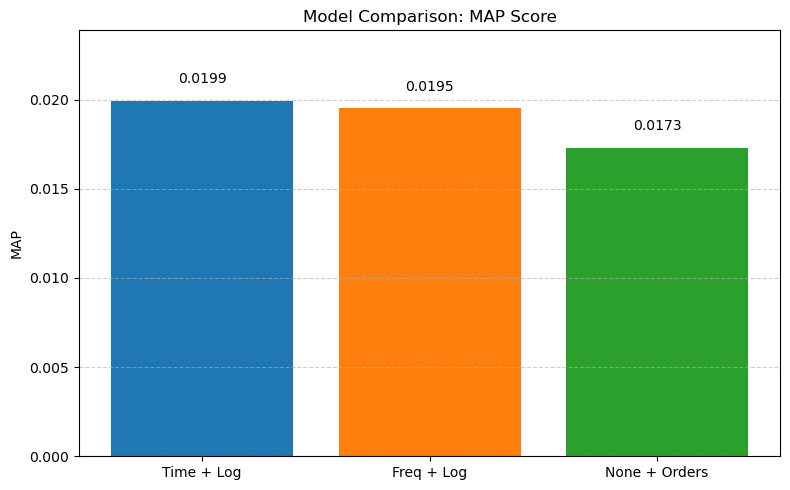

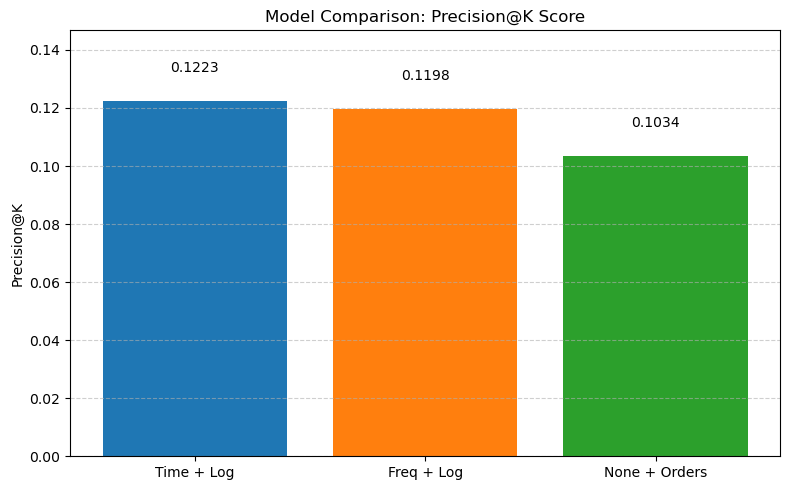

In [16]:
# Visualization Comparison Chart 1  
# Set three parameter configurations  
# "none + orders", "time + log", "frequency + log"(the former is weight methods of interaction marix, the latter is the scale method)
configs = [
    {"interaction_metod": "time", "scale_method": "log", "label": "Time + Log"},
    {"interaction_metod": "frequency", "scale_method": "log", "label": "Freq + Log"},
    {"interaction_metod": "none", "scale_method": "orders", "label": "None + Orders"},
]

# Common pipeline parameters
common_params = {
    "similarity_method": "svd",
    "sample_method": "stratified",
    "recommender_method": "knn",
    "k_nearest": 10,
    "test_orders_merged": test_orders_merged,
    "n_products": 2000,
    "n_sample_users": 30000,
    "n_recommendations": 10,
    "stratum_ratios": (0.99, 0.009, 0.001),
    "n_components": 50,
    "lambda_decay": 0.08,
}

# Store results  
results = []

# Iterate through each configuration and run the pipeline 
for config in configs:
    print(f"Running config: {config['label']}")
    pipeline = UserSimilarityRecommendationPipeline_new(prior_orders_merged, df_products)

    # Run the recommendation pipeline with specified parameters  
    scores = pipeline.run(
        similarity_method=common_params["similarity_method"],
        sample_method=common_params["sample_method"],
        interaction_metod=config["interaction_metod"],
        scale_method=config["scale_method"],
        recommender_method=common_params["recommender_method"],
        k_nearest=common_params["k_nearest"],
        test_orders_merged=common_params["test_orders_merged"],
        n_products=common_params["n_products"],
        n_sample_users=common_params["n_sample_users"],
        n_recommendations=common_params["n_recommendations"],
        stratum_ratios=common_params["stratum_ratios"],
        n_components=common_params["n_components"],
        lambda_decay=common_params["lambda_decay"]
     )

    # Append the results to the results list
    results.append({
        "label": config["label"],
        "MAP": scores["MAP"],
        "Precision@K": scores["Precision@K"]
    })

# === Visualization === #
labels = [r["label"] for r in results] # Extract labels for plotting 
map_scores = [r["MAP"] for r in results] # Extract MAP scores 
prec_scores = [r["Precision@K"] for r in results]  # Extract Precision@K scores

# Setting minimum values for truncation in plotting  
map_scores = [max(score, 0.01) for score in map_scores]  # Ensure MAP scores are at least 0.01  
prec_scores = [max(score, 0.05) for score in prec_scores]  # Ensure Precision@K scores are at least 0.05  


# Set colors (customizable)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# --- MAP Comparison Chart --- 
plt.figure(figsize=(8, 5))
plt.bar(labels, map_scores, color=colors)
plt.title("Model Comparison: MAP Score")
plt.ylabel("MAP")
plt.ylim(0, max(map_scores) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(map_scores):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.savefig(fig_save_path+'Model Comparison-MAP Score1.png')
plt.show()

# --- Precision@K Comparison Chart ---  
plt.figure(figsize=(8, 5))
plt.bar(labels, prec_scores, color=colors)
plt.title("Model Comparison: Precision@K Score")
plt.ylabel("Precision@K")
plt.ylim(0, max(prec_scores) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(prec_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.savefig(fig_save_path+'Model Comparison-Precision@K Score1.png')
plt.show()

In [ ]:
# Visualization Comparison Chart 2  
# Set three parameter configurations  
# "most_similar", "5 k_nearest", "10 k_nearest"

configs = [
    {"recommender_method": "most_similar", "k_nearest": 0, "label": "Top 1 similar aggregated"},
    {"recommender_method": "knn", "k_nearest": 5, "label": "Top 5 similar aggregated"},
    {"recommender_method": "knn", "k_nearest": 10, "label": "Top 10 similar aggregated"},
]

# Common pipeline parameters
common_params = {
    "similarity_method": "svd",
    "sample_method": "stratified",
    "interaction_metod": "frequency",
    "scale_method": "log",
    "test_orders_merged": test_orders_merged,
    "n_products": 1000,
    "n_sample_users": 30000,
    "n_recommendations": 10,
    "stratum_ratios": (0.90, 0.094, 0.006),
    "n_components": 50,
    "lambda_decay": 0.08,
}

# Store results
results = []

# Iterate through each configuration and run the pipeline 
for config in configs:
    print(f"Running config: {config['label']}")
    pipeline = UserSimilarityRecommendationPipeline_new(prior_orders_merged, df_products)

# Run the recommendation pipeline with specified parameters
    scores = pipeline.run(
        similarity_method=common_params["similarity_method"],
        sample_method=common_params["sample_method"],
        interaction_metod=common_params["interaction_metod"],
        scale_method=common_params["scale_method"],
        recommender_method=config["recommender_method"], 
        k_nearest=config["k_nearest"],
        test_orders_merged=common_params["test_orders_merged"],
        n_products=common_params["n_products"],
        n_sample_users=common_params["n_sample_users"],
        n_recommendations=common_params["n_recommendations"],
        stratum_ratios=common_params["stratum_ratios"],
        n_components=common_params["n_components"],
        lambda_decay=common_params["lambda_decay"]
     )

    # Append the results to the results list  
    results.append({
        "label": config["label"],
        "MAP": scores["MAP"],
        "Precision@K": scores["Precision@K"]
    })

Running config: Top 1 similar aggregated


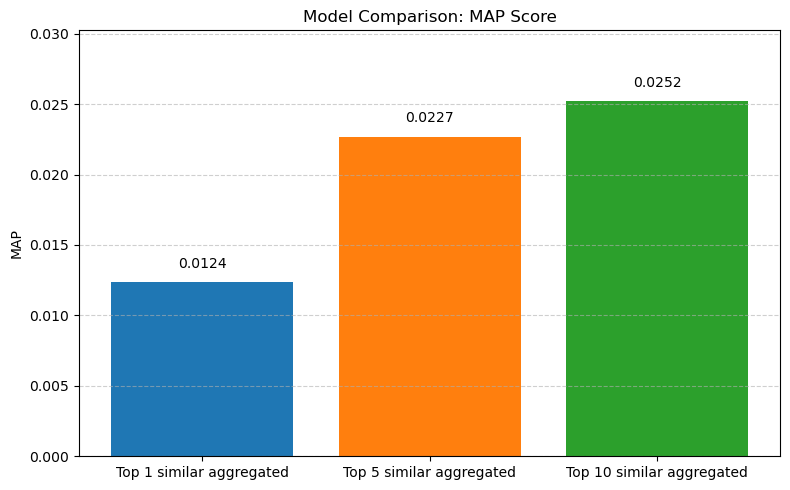

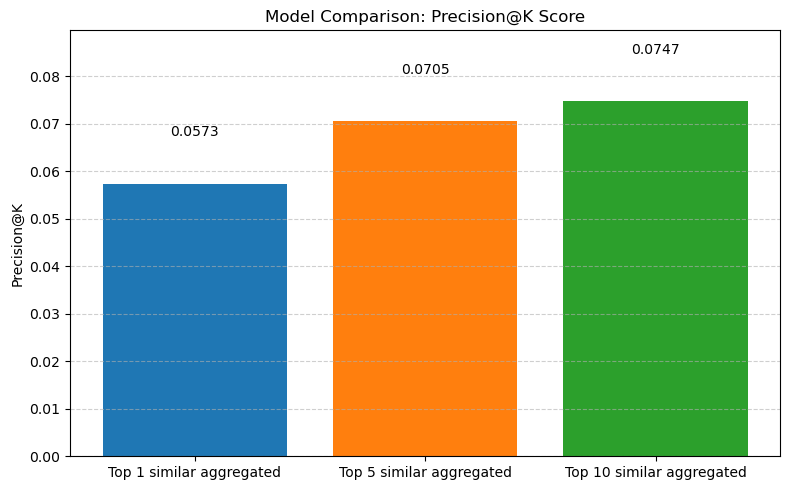

In [18]:
# === Visualization === #  
labels = [r["label"] for r in results]
map_scores = [r["MAP"] for r in results]
prec_scores = [r["Precision@K"] for r in results]

# Setting minimum values for truncation in plotting  
map_scores = [max(score, 0.01) for score in map_scores]  # Ensure MAP scores are at least 0.01  
prec_scores = [max(score, 0.05) for score in prec_scores]  # Ensure Precision@K scores are at least 0.05   

# Set colors (customizable) 
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# --- MAP Comparison Chart --- 
plt.figure(figsize=(8, 5))
plt.bar(labels, map_scores, color=colors)
plt.title("Model Comparison: MAP Score")
plt.ylabel("MAP")
plt.ylim(0, max(map_scores) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(map_scores):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.savefig(fig_save_path+'Model Comparison-MAP Score2.png')
plt.show()

# --- Precision@K Comparison Chart --- 
plt.figure(figsize=(8, 5))
plt.bar(labels, prec_scores, color=colors)
plt.title("Model Comparison: Precision@K Score")
plt.ylabel("Precision@K") 
plt.ylim(0, max(prec_scores) * 1.2) 
plt.grid(axis='y', linestyle='--', alpha=0.6) 
for i, v in enumerate(prec_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout() 
plt.savefig(fig_save_path+'Model Comparison-Precision@K Score2.png')
plt.show()